In [107]:
import cv2
import imageio
import numpy as np
import plotly.express as px
from skimage.morphology import skeletonize

In [129]:
def load_image(idx=0):
    vid = imageio.get_reader("Ludosport_birthday_sparring.mp4",  'ffmpeg')
    vid_iter = vid.iter_data()
    for _ in range(idx+1):
        image = next(vid_iter)
    return image

img = load_image(10)

sensitivity = 60
l_b = np.array([0, 0, 255 - sensitivity])   # lower hsv bound for white
u_b = np.array([255, sensitivity, 255])     # upper hsv bound for white

# convert to HSV for simplicity
blur = cv2.GaussianBlur(img, (5, 5), 0)
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, l_b , u_b)
kernel = np.ones((3, 3), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1) # dilate mask to make it easier

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(mask, low_threshold, high_threshold)
# edges = skeletonize(mask > 100).astype(np.uint8) # noticably slows down detection

rho = 1                         # distance resolution in pixels of the Hough grid
theta = np.pi / 180             # angular resolution in radians of the Hough grid
threshold = 30                  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 80            # minimum number of pixels making up a line
max_line_gap = 25               # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(
    edges, rho, theta, threshold, np.array([]),
    min_line_length, max_line_gap
)

if isinstance(lines, np.ndarray):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), 255, 2)


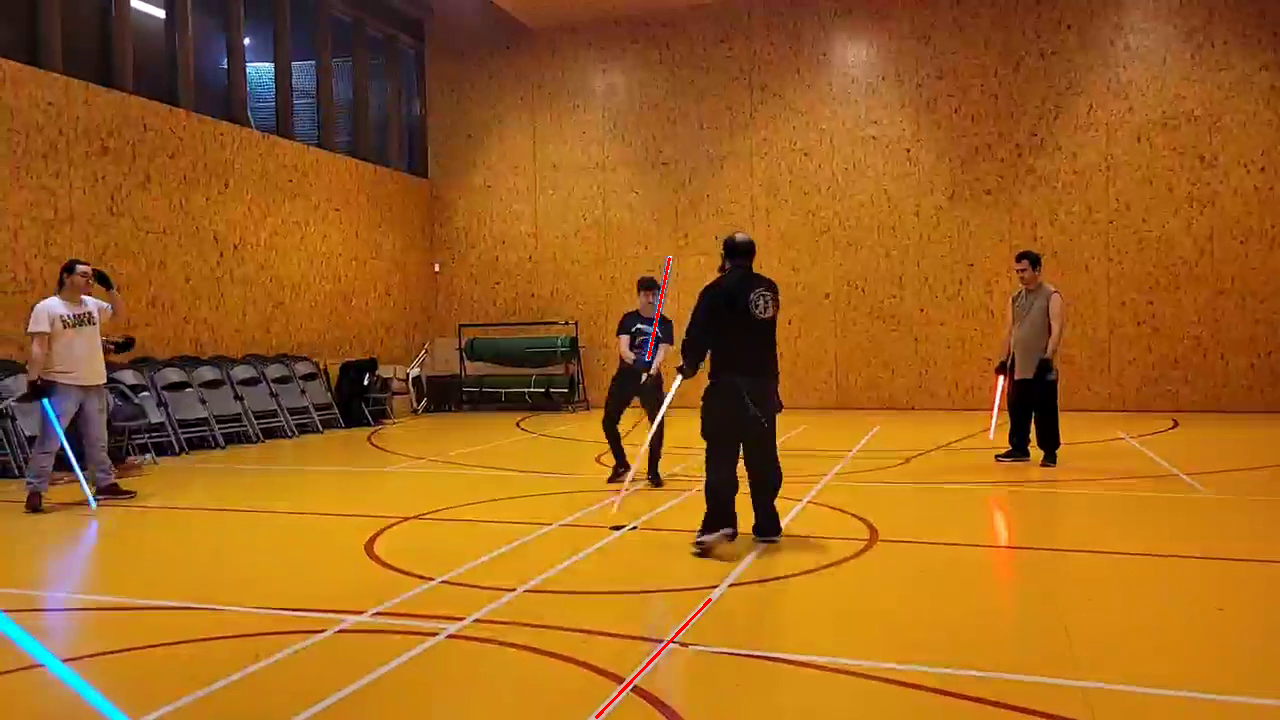

In [130]:
px.imshow(img)